# Introduction

The purpose of this project is to analyze nighttime aircraft noise complaints around San Francisco International Airport (SFO) to understand which neighborhoods are most affected. Specifically, we aim to:

Identify neighborhoods with the highest number of night-time complaints (8 PM–7 AM).

Examine how factors such as aircraft type, altitude, and operation type influence complaint patterns.

Build a predictive model to estimate future complaint levels and test how changes in flight operations could reduce noise.

By cleaning, analyzing, and modeling aircraft noise data from SFO, this project seeks to uncover meaningful insights that can help both residents and airport authorities address nighttime noise disturbances.

# Data Source

The dataset used in this project is the San Francisco International Airport (SFO) Aircraft Noise Reports, obtained from Data.gov :  https://catalog.data.gov/dataset/sfo-aircraft-noise-reports
. It contains aircraft noise complaints recorded by residents near SFO from 2018 to the present.

For this analysis, we focus only on night-time reports (8 PM–7 AM). The dataset includes variables such as disturbance date and time, reporter city and postal code, aircraft altitude, aircraft type, operation type, and airport ID, hour. Some cleaning was performed to remove missing values, filter SFO records, and ensure data consistency.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Download latest version of your dataset
df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")

# inspect dataset
df.head()


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_95044/1413754666.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")


,disturbance_date_time,report_method,corr_id,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,runway_name,flight_no,aircraft_type,destination_origin,data_as_of,data_loaded_at
0,2024/08/18 07:21:21 PM,Email,20662792,Palo Alto,94301,4911.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
1,2024/08/18 07:21:42 PM,AWA App,20662333,Portola Valley,94028,4610.0,SFO,A,28L,ASA129,B739,LAS,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
2,2024/08/18 07:21:46 PM,AWA App,20662792,Palo Alto,94303,4803.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
3,2024/08/18 07:24:40 PM,AWA App,20663178,Redwood City,94061,4390.0,SFO,A,28R,UAL1947,B39M,HNL,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
4,2024/09/13 07:09:59 PM,AWA App,20692087,Santa Cruz,95065,11378.0,SFO,A,28L,UAL2320,B739,LAX,2024/11/07 05:04:54 PM,2025/10/07 06:22:50 AM


# Clean and Prepare Data

In [3]:

# Load only needed columns from the CSV to save memory
columns_to_load = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type'
]


In [4]:

# Step 1: Drop rows with missing values in essential columns first
essential_columns = ['disturbance_date_time', 'reporter_postal_code', 'airport_id', 'operation_type']
df = df.dropna(subset=essential_columns)


In [5]:

# Step 2: Filter for SFO airport and operation type (Arrival/Departure)
df = df[(df['airport_id'] == 'SFO') & (df['operation_type'].isin(['A', 'D']))]


In [6]:

# Step 3: Convert disturbance_date_time to datetime (after dropping nulls to save time)

df['disturbance_date_time'] = pd.to_datetime(
    df['disturbance_date_time'],
    format="%Y/%m/%d %I:%M:%S %p",  # note %I for 12-hour and %p for AM/PM
    errors='coerce'
)


In [7]:

# Step 4: Drop rows where conversion failed (NaT values)
df = df.dropna(subset=['disturbance_date_time'])


In [8]:

# Step 5: Extract hour for night-time filtering
df['hour'] = df['disturbance_date_time'].dt.hour


In [9]:

# Step 6: Filter for night-time complaints (8 PM - 7 AM)
df = df[(df['hour'] >= 20) | (df['hour'] <= 7)]

# Remove duplicates
df = df.drop_duplicates()

# Step 7: Reset index
df = df.reset_index(drop=True)


In [10]:
# keep only the needed columns
columns_needed = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type', 'hour'
]

df = df[columns_needed]

In [11]:
# Save the cleaned dataset
df.to_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv", index=False)

print("Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv")

Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv


In [12]:
df.head()

,disturbance_date_time,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,aircraft_type,hour
0,2024-08-18 20:03:17,Portola Valley,94028,5007.0,SFO,D,B77W,20
1,2024-08-18 20:13:19,Los Altos Hills,94024,6644.0,SFO,A,E75L,20
2,2024-08-18 20:12:53,Mountain View,94040,6296.0,SFO,A,E75L,20
3,2024-08-18 20:10:30,San Francisco,94124,4678.0,SFO,D,B738,20
4,2024-08-18 20:15:16,Mountain View,94040,6296.0,SFO,A,E75L,20


# Exploratory Data Analysis

Count complaints by city 

In [13]:
complaints_by_city = (
    df.groupby('reporter_city').size().reset_index(name='complaint_count')
)
complaints_by_city = complaints_by_city.sort_values(by='complaint_count', ascending=False)

complaints_by_city.head(10)

,reporter_city,complaint_count
46,Palo Alto,539153
50,Portola Valley,277261
60,Santa Cruz,217696
33,Los Altos,207734
62,Scotts Valley,110485
64,Soquel,100524
35,Los Gatos,79328
41,Mountain View,57824
34,Los Altos Hills,52609
55,San Francisco,49004


Bar plot shows the top 15 most affected neighborhoods

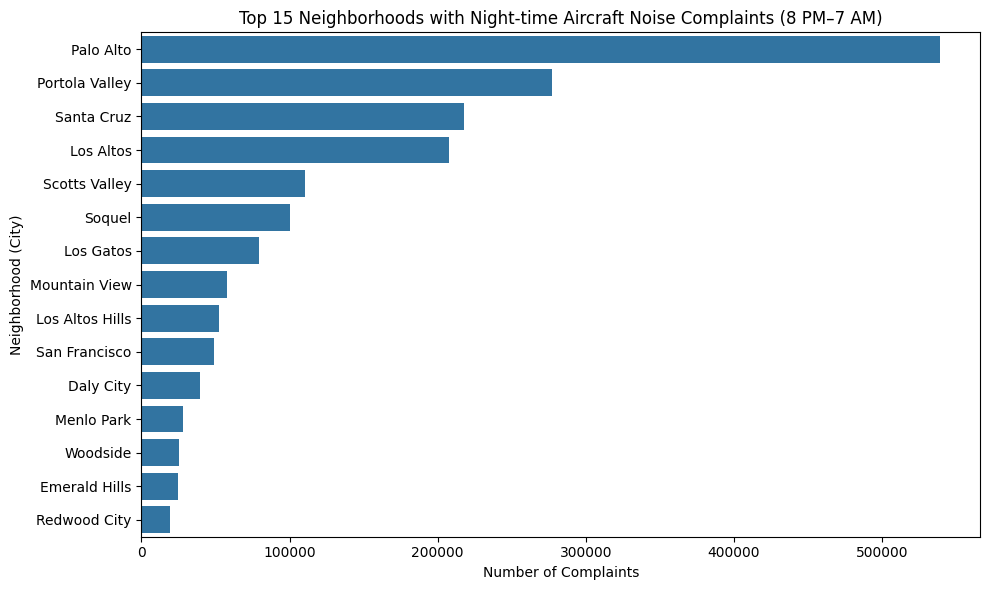

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=complaints_by_city.head(15),
    x="complaint_count",
    y="reporter_city"
)
plt.title("Top 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)")
plt.xlabel("Number of Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


We will create new column that shows how much the distance from each of these neighborhood are from SFO, then we could give stronger support to the findings.

For now, the answers show Palo Alto has the most complaints. Redwood city has the lowest.

Next we will find contributing factor to this. (Altitude)

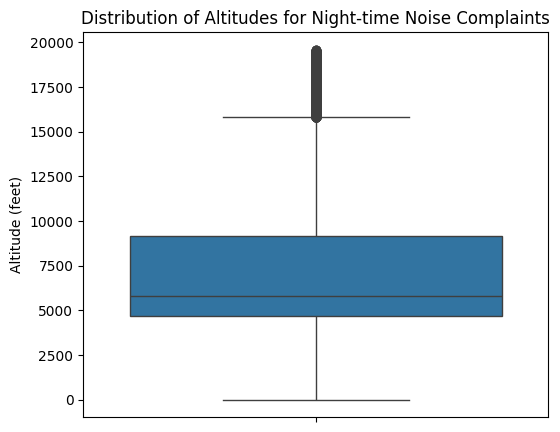

In [15]:
df_alt = df.dropna(subset=['aircraft_pca_altitude'])
df_alt = df_alt[df_alt['aircraft_pca_altitude'] > 0]

plt.figure(figsize=(6,5))
sns.boxplot(data=df_alt, y="aircraft_pca_altitude")
plt.title("Distribution of Altitudes for Night-time Noise Complaints")
plt.ylabel("Altitude (feet)")
plt.show()


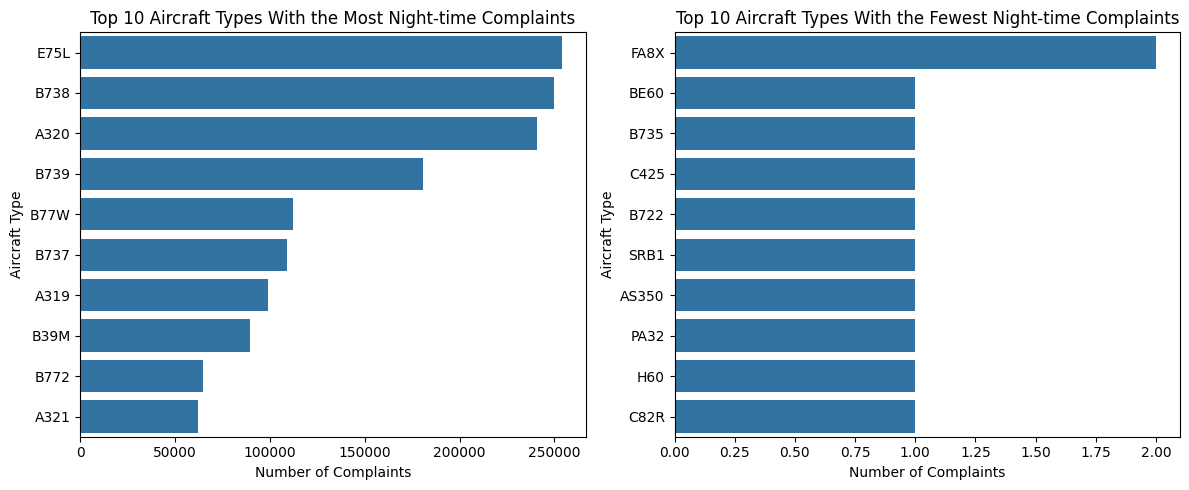

In [16]:
# Count complaints by aircraft type
complaints_by_aircraft = (
    df.groupby('aircraft_type')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='num_complaints', ascending=False)
)

complaints_by_aircraft.head()

# Take top 15 aircraft types by number of complaints
top10_high = complaints_by_aircraft.head(10)
top10_low = complaints_by_aircraft.tail(10)


plt.figure(figsize=(12,5))

# Top 10 highest
plt.subplot(1,2,1)
sns.barplot(data=top10_high, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Most Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

# Top 10 lowest
plt.subplot(1,2,2)
sns.barplot(data=top10_low, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Fewest Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

plt.tight_layout()
plt.show()





TIME AT NIGHT THAT GENERATE THE MOST AND LEAST COMPLAINT

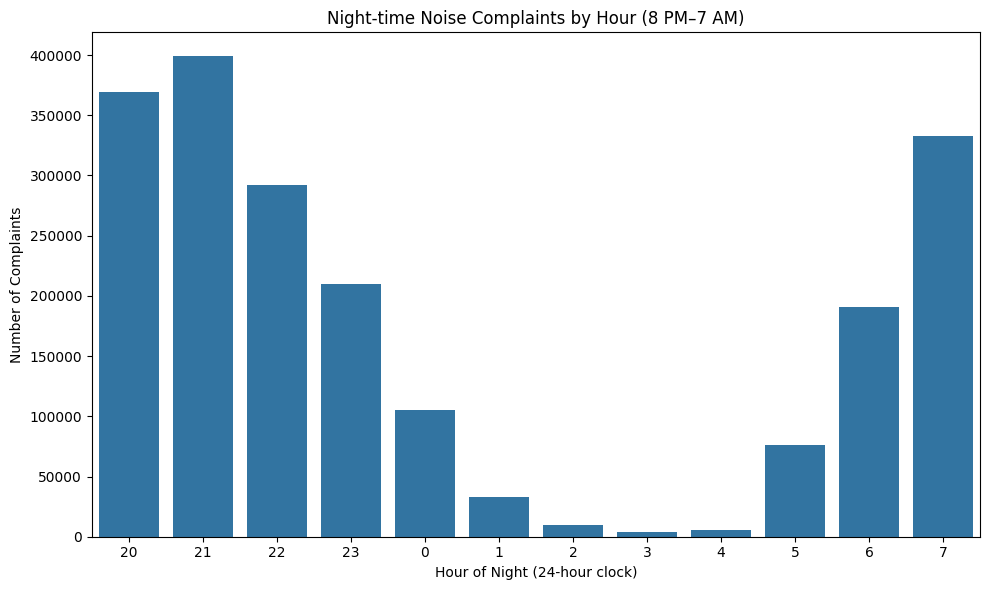

Hour with MOST complaints: 21 with 398915 complaints
Hour with LEAST complaints: 3 with 3795 complaints


In [17]:
# Count complaints for each hour in the night period
complaints_by_hour = (
    df.groupby('hour')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='hour')
)
# Count complaints for each hour in the night period
# Define the night hours in order
night_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]

# Make 'hour' a categorical variable with this order
complaints_by_hour['hour'] = pd.Categorical(
    complaints_by_hour['hour'],
    categories=night_hours,
    ordered=True
)

plt.figure(figsize=(10,6))
sns.barplot(data=complaints_by_hour, x='hour', y='num_complaints')
plt.title("Night-time Noise Complaints by Hour (8 PM–7 AM)")
plt.xlabel("Hour of Night (24-hour clock)")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

most = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmax()]
least = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmin()]

print("Hour with MOST complaints:", int(most['hour']), "with", int(most['num_complaints']), "complaints")
print("Hour with LEAST complaints:", int(least['hour']), "with", int(least['num_complaints']), "complaints")


TIME OF YEAR SEASONAL COMPLAINT

In [18]:
# Function to assign season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Create a new 'season' column
df['season'] = df['disturbance_date_time'].dt.month.apply(month_to_season)


# Count complaints by season
complaints_by_season = df['season'].value_counts().reindex(['Winter','Spring','Summer','Fall'])



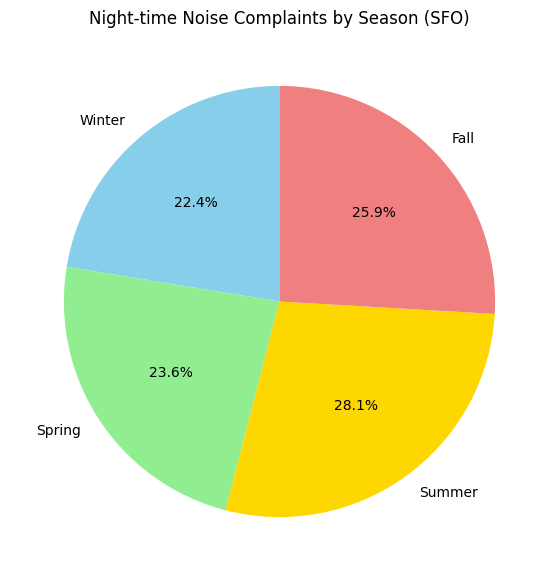

In [19]:
plt.figure(figsize=(7,7))
plt.pie(
    complaints_by_season,
    labels=complaints_by_season.index,
    autopct='%1.1f%%',  # show percentages
    colors=['skyblue','lightgreen','gold','lightcoral'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Season (SFO)")
plt.show()



COUNT COMPLAINTS BY OPERATION TYPE

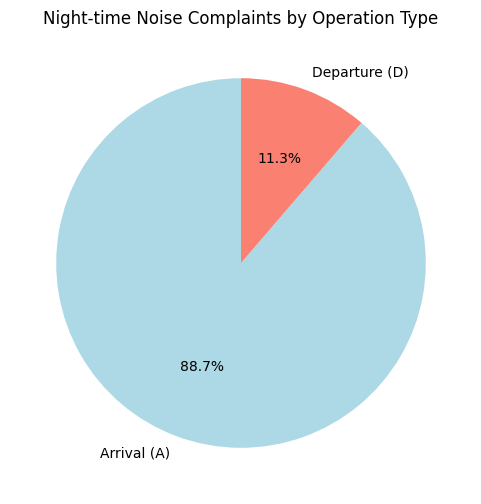

In [20]:
complaints_by_operation = df['operation_type'].value_counts().reindex(['A','D'])



plt.figure(figsize=(6,6))
plt.pie(
    complaints_by_operation,
    labels=['Arrival (A)', 'Departure (D)'],
    autopct='%1.1f%%',
    colors=['lightblue','salmon'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Operation Type")
plt.show()


# Modeling

Predictive Modeling Using Random Forest

To predict night-time aircraft noise complaints per neighborhood and analyze the effect of increasing flight altitude, we use a Random Forest Regression model. This model is ideal because it can handle non-linear relationships and high-cardinality categorical variables, such as aircraft type.

Now we groups the complaints by neighborhood, time of night, type of flight, and type of aircraft. It then counts how many complaints happened for each group and calculates the average altitude of the planes.

In [ ]:
# Aggregate complaints by neighborhood, hour, operation type, and aircraft type
df_model = (
    df.groupby(['reporter_city', 'hour', 'operation_type', 'aircraft_type'])
      .agg({
          'aircraft_pca_altitude': 'mean',   # average altitude
          'reporter_city': 'count'           # number of complaints
      })
      .rename(columns={'reporter_city': 'complaint_count'})
      .reset_index()
)

# Quick check
print(df_model.head())
print("Total rows after aggregation:", len(df_model))



  reporter_city  hour operation_type aircraft_type  aircraft_pca_altitude  \
0       Alameda     0              A          A320            3077.800000   
1       Alameda     0              A          B738            2850.000000   
2       Alameda     0              A          B739            3180.750000   
3       Alameda     0              A          E75L            3116.000000   
4       Alameda     1              A          A320            3032.666667   

   complaint_count  
0                5  
1                7  
2                4  
3                3  
4                3  
Total rows after aggregation: 3283


This code turns the text columns into numbers and picks the important columns to teach the model how to predict the number of complaints.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Copy dataset
df_rf = df_model.copy()

# converts text categories into numbers
# Encode aircraft_type
le_aircraft = LabelEncoder()
df_rf['aircraft_type_enc'] = le_aircraft.fit_transform(df_rf['aircraft_type'])

# Encode operation_type
le_op = LabelEncoder()
df_rf['operation_type_enc'] = le_op.fit_transform(df_rf['operation_type'])

# Features and target
X = df_rf[['hour', 'aircraft_pca_altitude', 'aircraft_type_enc', 'operation_type_enc']]
y = df_rf['complaint_count']


Training the Random Forest Model

We train a Random Forest regressor with 100 trees and a maximum depth of 10 to predict complaint counts.

In [ ]:
# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# Evaluate model performance
print("Random Forest R²:", rf.score(X, y))


Random Forest R²: 0.6982862520385114


The model achieves an R² of 0.698, meaning it explains about 70% of the variation in complaints.

Scenario Analysis: Increasing Altitude

To simulate the effect of raising flight altitude by 1000 ft, we create a copy of the feature dataset and increase the aircraft_pca_altitude column. Predicted complaints are compared to the original predictions to calculate the change in complaints for each neighborhood.

In [104]:
# Simulate higher altitude
X_scenario = X.copy()
X_scenario['aircraft_pca_altitude'] += 1000

# Predict complaints
y_pred_original = rf.predict(X)
y_pred_scenario = rf.predict(X_scenario)

# Calculate change in complaints
df_rf['predicted_change'] = y_pred_scenario - y_pred_original

# Top 10 neighborhoods with largest predicted decrease in complaints
top_neighborhoods = df_rf.groupby('reporter_city')['predicted_change'].mean().nsmallest(10).reset_index()
top_neighborhoods.columns = ['reporter_city', 'avg_change_in_complaints']
print(top_neighborhoods)


     reporter_city  avg_change_in_complaints
0        Palo Alto              -1225.555345
1       Santa Cruz               -925.826424
2           Soquel               -669.751214
3   Portola Valley               -554.460211
4        Los Altos               -336.883043
5    Mountain View               -232.855273
6            Aptos               -228.200157
7         Capitola               -227.974865
8  Los Altos Hills               -205.237563
9         Woodside               -166.654391


Visualization

We can visualize the top 10 neighborhoods that are predicted to experience the largest drop in complaints if flights fly 1000 ft higher.

/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_95044/2314423700.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


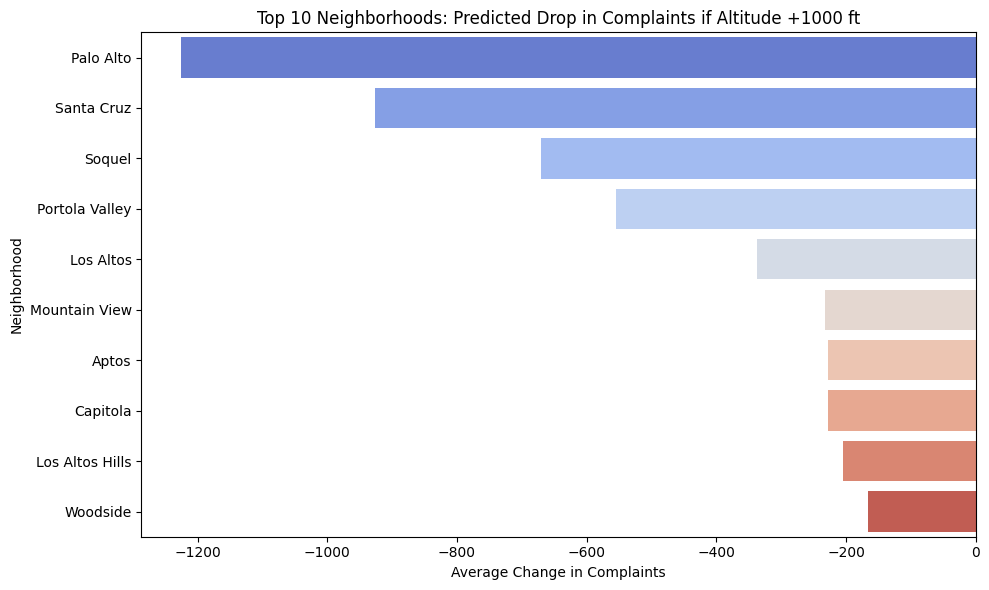

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

top10_sorted = top_neighborhoods.sort_values(by='avg_change_in_complaints')

plt.figure(figsize=(10,6))
sns.barplot(
    x='avg_change_in_complaints',
    y='reporter_city',
    data=top10_sorted,
    palette='coolwarm'
)
plt.title('Top 10 Neighborhoods: Predicted Drop in Complaints if Altitude +1000 ft')
plt.xlabel('Average Change in Complaints')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()


Visualization Interpretation

The chart shows the top 10 neighborhoods predicted to experience the largest reduction in night-time aircraft noise complaints if flight altitudes increase by 1000 ft. Palo Alto would benefit the most (-1,226 complaints), followed by Santa Cruz (-926) and Soquel (-670). Other neighborhoods like Portola Valley and Los Altos also see notable decreases.

K-fold cross validaiton

This code tests how well the Random Forest model can predict noise complaints. It splits the data into 5 parts, trains on most of it, tests on the rest, and repeats this 5 times to see how accurate the model is. It measures how much of the complaints it can explain (R²) and how far off the predictions are on average (MAE).

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
import numpy as np

# Features and target
X = df_rf[['hour', 'aircraft_pca_altitude', 'aircraft_type_enc', 'operation_type_enc']]
y = df_rf['complaint_count']

# Initialize Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # negative MAE

# R² scores
r2_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
# MAE scores (negative, so multiply by -1 to get positive)
mae_scores = -cross_val_score(rf, X, y, cv=kf, scoring=mae_scorer)

# Print results
print("R² scores for each fold:", r2_scores)
print("Mean R²:", np.mean(r2_scores))
print("MAE for each fold:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))


R² scores for each fold: [ 0.27962791 -0.08002251  0.00726957  0.18586941  0.17954147]
Mean R²: 0.11445717219313076
MAE for each fold: [294.03044578 433.84247731 356.92541295 458.0753751  401.82597463]
Mean MAE: 388.93993715289184
